# 목차

Step 1. 데이터 수집하기  
Step 2. 데이터 전처리하기  
Step 3. SubwordTextEncoder 사용하기  
Step 4. 모델 구성하기  
Step 5. 모델 평가하기  

# 학습목표

1. 트랜스포머의 인코더 디코더 구조 이해하기
2. 어텐션 속 셀프 어텐션
3. 내부 단어 토크나이저 사용하기 (SubwordTextEncoder)
4. 한국어에도 적용해보기  

## 1. 트랜스포머의 인코더 디코더 구조 이해하기

![](https://aiffelstaticprd.blob.core.windows.net/media/images/Untitled_UcFQAjh.max-800x600.png)

트랜스포머 또한 번역기와 마찬가지로 기본적으로 인코더와 디코더 구성을 가지고 있다  
![](https://aiffelstaticprd.blob.core.windows.net/media/images/Untitled_2_EnQyi4S.max-800x600.png)

^트랜스포머의 내부구조  
초록색 색깔의 도형 : 인코더 층(Encoder layer), 핑크색 색깔의 도형 : 디코더(Decoder layer)  
더 자세히 보면 아래와 같다.  
![](https://aiffelstaticprd.blob.core.windows.net/media/images/Untitled_3_ddZedfW.max-800x600.png)

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_4_fuzN6PD.png)

+ 위의 embedding vector로 들어가는 부분이 단어를 벡터화하는 과정   
+ 트랜스포머 모델이 RNN 계열 모델과 다른 점 -> 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용    
  그 어떤 값은  위 그림에서의 포지셔널 인코딩(positional Encoding)에 해당  
+ ![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_5_kH52kQN.png)

+ 포지셔널 인코딩을 더해주는 이유  
  => 문장에 있는 단어를 한꺼번에 받기 때문에 위치 정보를 가진 포시셔널 인코딩으로 순서를 부여한다  
  


![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_7_3Rneu0P.png)
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_6_DyxB6Ax.png)

>* 위의 행렬 = 임베딩 벡터가 모여 만들어진 문장 벡터 행렬 + 포지셔널 인코딩 행렬  
>* d_model은 임베딩 벡터의 차원을 의미    
>* pos는 입력 문장에서의 임베딩 벡터의 위치 (각각의 토큰의 위치정보값, 정수값)   
>* i는 임베딩 벡터 내의 차원의 인덱스를 의미  
>* 0부처 d차원까지의 값 :   
   짝수일 때는 -> sin 함수  
   홀수일 때는 -> cos 함수

**Q1. 한 문장에 같은 단어 A가 여러 번 등장하였다고 가정해보겠습니다.   
임베딩 문장 행렬에 포지셔널 인코딩을 해주었을 때와 해주지 않았을 때,   
트랜스포머가 임베딩 문장 행렬 내의 다수의 A 단어 벡터로부터 얻을 수 있는 정보의 차이는 어떤 것이 있을까요?**
>같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로,  
같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있습니다.  

아래에서 포지셔널 행렬을 직접 구현해서 눈으로 확인해보자  

In [17]:
# from wikidocs
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 512)


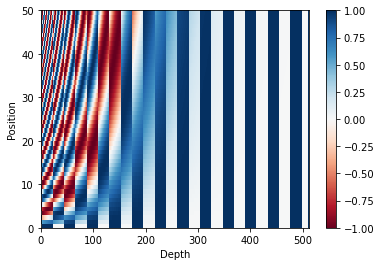

In [20]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [26]:
# 포지셔널 인코딩 레이어
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


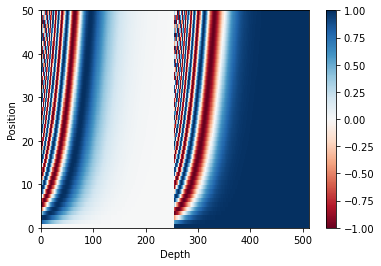

In [28]:
# 최대 문장의 길이가 50, 워드 임베딩 차원을 512 = (50,512)
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

* ^sin, cos 결과가 겹치지 않음을 가시적으로 표현함  
참조 : 진표 퍼실님 & https://wikidocs.net/31379  

## 2. 어텐션 속 셀프 어텐션

우선 어텐션에 대해 알아보자  

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_12_SIe2V15.png)

**^각 어텐션이 위치를 보여줌**  
트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value)는 기본적으로 '단어 (정보를 함축한) 벡터'  
여기서 '단어 벡터'란 초기 입력으로 사용되었던 임베딩 벡터가 아니고,  
트랜스포머의 여러 연산을 거친 후의 '단어 벡터'이다. 

셀프 어텐션까지의 과정 : 트랜스포머 -> 단어벡터(쿼리, 키, 밸류) -> 어텐션 값  

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_10_AaCfqrY.png)

주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구하고  
-> 구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영  
-> 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 => 어텐션 값(Attention Value)  
=> 그런데 쿼리, 키, 값에 포커싱을 두지 말고 그냥 어텐션은 '유사도를 찾는 것'이라고 이해합니다.  
  
트랜스포머는 총 세 가지의 어텐션을 사용  
>인코더 셀프 어텐션은 인코더  
디코더 셀프 어텐션은 디코더  
인코더-디코더 어텐션 또한 디코더

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_11_tFFhFjx.png)

**^세 가지 어텐션이 하는 일**  
* 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다. 
* 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다. 
* 인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.  

**셀프 어텐션(Self Attention)**  
셀프 어텐션은 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말한다  

**유사도**  
$$ 유사도 = (Q * K^{T})/sqrt(d_k) $$

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_15_pUfIgKn.png)  
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/Untitled_16_neA52rZ.png)

* Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.  
* 두 벡터의 내적(dot product)은 두 벡터에 근접한 위치를 향하는 것    
* 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.   
* 위의 초록색 행렬은 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬  
  => 초록(2, 4)의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값(유사도)  
* 스케일링 해주기 위해서 이 행렬 전체를 특정 값으로 나눠주고  
* 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용  
* Q와 K를 내적 후 스케일링 해줬다고 해서 Scaled Dot Product Attention이라고 합니다.

## 3. 내부 단어 토크나이저 사용하기 (SubwordTextEncoder)

SubwordTextEncoder는 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저이다.  
또한 SubwordTextEncoder는 형태소 분석기 중 하나이다.  
단어보다 더 작은 단위인 Subword를 기준으로 분리해준다.  
```
tfds.deprecated.text.SubwordTextEncoder(subwords, vocab_size=Size of the vocabulary)
```
참조 : https://arxiv.org/pdf/1806.05482.pdf  
형태소 분석기를 쓰지 않고 서브워드 테크나이저의 차이

## 4. 한국어에도 적용해보기  

영어와 과정은 비슷하고 전처리만 차이가 있다.

# Step 1. 데이터 수집하기

```
! pip install tensorflow-datasets
```

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv

--2021-03-09 02:05:39--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 52.78.231.108
Connecting to github.com (github.com)|52.78.231.108|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-03-09 02:05:40--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv.1’

ChatbotData .csv.1  100%[===================>] 868.99K  4.53MB/s    in 0.2s    

2021-03-09 02:05:40 (4.53 MB/s) - ‘ChatbotData .csv.1’ saved [889842/889842]



In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


In [5]:
# scaled dot product attention
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산"""
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_pk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk/tf.math.sqrt(depth)
    
  # add the mask to zero out padding tokens
  if mask is not None:
    logits+=(mask * -1e9)

  # softmax is normalized on the last axis (swq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)
    
  output = tf.matmul(attention_weights, value)

  return output

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [7]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [8]:
print(create_padding_mask(tf.constant([[1,2,0,3,0],[0,0,0,4,5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [9]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [11]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [13]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

	# 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
	# 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

	# 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

	# Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#  Step 2. 데이터 전처리하기

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/songys_chatbot/ChatbotData .csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [17]:
questions = df['Q']
answers = df['A']

In [18]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 8000
print(MAX_SAMPLES)

8000


전체 샘플 개수 11823개를 모두 사용할 때보다  
약간 적게 사용할 때 챗봇의 대답이 자연스럽다.  
전체 데이터를 모두 쓰면 오버핏팅된다고 추측할 수 있다.

## 영어와 다른 전처리

In [19]:
# 전처리 함수
def preprocess_sentence(sentence):
#   sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#   sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
#   sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [20]:
## 이 부분은 
# # 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
# def load_conversations():
#   id2line = {}
#   with open(path_to_movie_lines, errors='ignore') as file:
#     lines = file.readlines()
#   for line in lines:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     id2line[parts[0]] = parts[4]

#   inputs, outputs = [], []
#   with open(path_to_movie_conversations, 'r') as file:
#     lines = file.readlines()

#   for line in lines:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

#     for i in range(len(conversation) - 1):
# 			# 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
#       inputs.append(preprocess_sentence(id2line[conversation[i]]))
#       outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

#       if len(inputs) >= MAX_SAMPLES:
#         return inputs, outputs
#   return inputs, outputs
# print("슝=3")

In [21]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
# questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [22]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


# Step 3. SubwordTextEncoder 사용하기

In [23]:
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [24]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [25]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


In [26]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8363


In [27]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5824, 602, 2498, 4170]
정수 인코딩 후의 21번째 답변 샘플: [2683, 7666, 6, 6375, 92, 8151]


In [28]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [29]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [30]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [31]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


# Step 4. 모델 구성하기

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [34]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

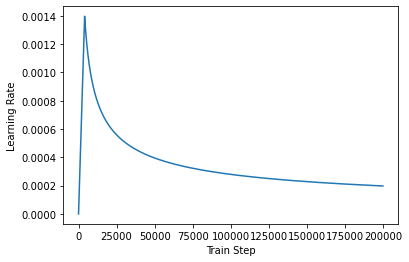

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [38]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 13s 68ms/step - loss: 1.4606 - accuracy: 0.0302
Epoch 2/20
185/185 [==============================] - 13s 69ms/step - loss: 1.1840 - accuracy: 0.0495
Epoch 3/20
185/185 [==============================] - 12s 68ms/step - loss: 1.0074 - accuracy: 0.0508
Epoch 4/20
185/185 [==============================] - 13s 72ms/step - loss: 0.9329 - accuracy: 0.0543
Epoch 5/20
185/185 [==============================] - 13s 69ms/step - loss: 0.8738 - accuracy: 0.0575
Epoch 6/20
185/185 [==============================] - 13s 69ms/step - loss: 0.8144 - accuracy: 0.0616
Epoch 7/20
185/185 [==============================] - 13s 69ms/step - loss: 0.7488 - accuracy: 0.0676
Epoch 8/20
185/185 [==============================] - 13s 68ms/step - loss: 0.6762 - accuracy: 0.0754
Epoch 9/20
185/185 [==============================] - 13s 69ms/step - loss: 0.5968 - accuracy: 0.0839
Epoch 10/20
185/185 [==============================] - 13s 70ms/step - loss: 0.514

# Step 5. 모델 평가하기

In [39]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [41]:
sentence_generation('이름')

입력 : 이름
출력 : 위로봇이요.


'위로봇이요.'

In [42]:
sentence_generation('술 좋아해?')

입력 : 술 좋아해?
출력 : 저는 주당이에요.


'저는 주당이에요.'

In [43]:
sentence_generation('밥 먹자')

입력 : 밥 먹자
출력 : 맛있게 드세요.


'맛있게 드세요.'

In [44]:
sentence_generation('언제와?')

입력 : 언제와?
출력 : 그런 생각은 스스로의 우선순위를 정해보세요.


'그런 생각은 스스로의 우선순위를 정해보세요.'

In [45]:
sentence_generation('영화 좋아해?')

입력 : 영화 좋아해?
출력 : 최신 영화 추천해드립니다.


'최신 영화 추천해드립니다.'

In [46]:
sentence_generation('뭐 먹을래?')

입력 : 뭐 먹을래?
출력 : 기분 좋으시겠어요.


'기분 좋으시겠어요.'

In [47]:
sentence_generation('운전할 수 있어?')

입력 : 운전할 수 있어?
출력 : 미리 양해를 구해야 해요.


'미리 양해를 구해야 해요.'

In [48]:
sentence_generation('안녕')

입력 : 안녕
출력 : 안녕하세요.


'안녕하세요.'

In [49]:
sentence_generation('소주 맥주')

입력 : 소주 맥주
출력 : 피할 수 있으면 피하세요.


'피할 수 있으면 피하세요.'

In [50]:
sentence_generation('사람은 무엇으로 살아가니')

입력 : 사람은 무엇으로 살아가니
출력 : 그런 남자 버리시길 바랄게요.


'그런 남자 버리시길 바랄게요.'

In [51]:
sentence_generation('그 사람을 못 잊겠어')

입력 : 그 사람을 못 잊겠어
출력 : 완전히 잊을 수는 없지만 새로운 사랑으로 잊혀질 수도 있어요.


'완전히 잊을 수는 없지만 새로운 사랑으로 잊혀질 수도 있어요.'

In [52]:
sentence_generation('너는 애인있어?')

입력 : 너는 애인있어?
출력 : 이제 남이라는 걸 잊지 마세요.


'이제 남이라는 걸 잊지 마세요.'

# 루브릭

평가문항
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.  
   공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.  
   -> ok
   
   
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.  
   구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.  
   -> ok
   
   
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.  
   한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.  
   -> ok  
   

# 궁금했던 점
- 포지셔닝 인코딩 레이어에서 벡터의 시각화 한 부분  
  -> sin 과 cos의 결과가 겹치지 않음을 시각화함
  
  
- 트랜스포머와 어텐션의 관계
>트랜스포머 -> 단어벡터(쿼리, 키, 밸류) -> 어텐션 값  
   
   
   
- 유사도

# 고찰

자연어 프로젝트 중에 가장 흥미로웠다.  
여전히 코드를 모두 이해한건 아니지만, 대략의 구조는 이해할 수 있게 되었다.  
특히 트랜스포머에 포지셔널 인코딩을 해주는 아이디어가 아주 멋있었다.  
다음에는 어텐션의 query, key, value에 대해 더 자세하게 배우고 이해하고 싶다.